In [1]:
import os
import copy
from coffea import hist
from coffea import util
import numpy as np
import itertools
import pandas as pd
import uproot3

In [2]:
def printColorText(text, color): # both the input text and the color desired are input as strings
    whichcolor = {
                    'red':'\033[91m' + text,
                    'yellow':'\033[93m' + text,
                    'green':'\033[92m' + text,
                    'blue':'\033[96m' + text,
                    'indigo':'\033[94m' + text,
                    'violet':'\033[95m' + text,
                }
    print(whichcolor.get(color) + '\033[90m')
    # The added string on the end resets the default colored text to black #

# ---- Test the function ---- #
print('this sentence is black by default')
printColorText('this sentence should be violet', 'violet')
print('this sentence is defaulted to black after printColorText')

this sentence is black by default
this sentence should be violet
this sentence is defaulted to black after printColorText


In [3]:
dir1 = 'CoffeaOutputsForCombine/Coffea_FirstRun/'
dir2 = 'CoffeaOutputsForCombine/Coffea_SecondRun/'
btagDir = 'MediumBTag/'#'LooseBTag/'
yearDir = '2016/'
APVDir = 'noAPV/'
od = ''


if btagDir == '':
    od = '_oldANdisc'

# Systematic Correction / Uncertainty + Reweighting Label
## Set the strings accordingly
#### For bTagSyst: '_btagUnc_\<syst\>' where \<syst\> can be either $central$, $up$ or $down$
#### For Top $p_T$ Reweight: '_TopReweight'

In [4]:
Unc = '' #_btagUnc_central_method2
TopPt = '' #_TopReweight
UncDir = Unc + '/'
TopPtDir = TopPt + '/'

In [5]:
JetHT2016_str = 'TTbarRes_0l_JetHT2016_Data'
TTbar_str = 'TTbarRes_0l_UL16postVFP_TTbar'

In [6]:
JetHT2016_wgt_str = JetHT2016_str + '_weighted' + Unc
TTbar_wgt_str = TTbar_str + '_weighted' + Unc + TopPt

## Import First Uproot Job Coffea Outputs (Unweighted by Mistag Rates)

In [7]:
JetHT2016_unweighted = util.load(dir1 + 'JetHT/' + btagDir + yearDir + JetHT2016_str + od + '.coffea')
TTbar_unweighted = util.load(dir1 + 'TT/' + btagDir + yearDir + APVDir + TTbar_str + od + '.coffea')

## Import Second Uproot Job Coffea Outputs (Weighted by Mistag Rates)

In [8]:
JetHT2016_weighted = util.load(dir2 + 'JetHT/' + btagDir + yearDir + JetHT2016_wgt_str + od + '.coffea')
TTbar_weighted = util.load(dir2 + 'TT/' + btagDir + yearDir + APVDir + TTbar_wgt_str + od + '.coffea')

## Cutflow

In [9]:
outputs_unweighted =     {'JetHT 2016': JetHT2016_unweighted,
                          'TTbar': TTbar_unweighted
                         }

outputs_weighted  =      {'JetHT 2016': JetHT2016_weighted,
                          'TTbar': TTbar_weighted
                         }

In [10]:
for name,output in outputs_unweighted.items(): 
    print("-------Unweighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

-------Unweighted JetHT 2016--------
          all events :     42866596
                sumw :     42866596
               sumw2 :     42866596
              HT Cut :      7212257
        Loose Jet ID :      7093625
            pT,y Cut :      5708686
         two FatJets :      3326171
         >= oneTTbar :      3326171
            dPhi Cut :      1662798
        Good Subjets :      1622317
          AT&Pt0bcen :         2474
          AT&Pt0bfwd :         2259
          AT&Pt1bcen :         2051
          AT&Pt1bfwd :         2048
          AT&Pt2bcen :          526
          AT&Pt2bfwd :          499
             at0bcen :        67683
             at0bfwd :        67268
             at1bcen :        44687
             at1bfwd :        48151
             at2bcen :         8005
             at2bfwd :         8841
           pret0bcen :        17168
           pret0bfwd :        16318
           pret1bcen :        12399
           pret1bfwd :        13188
           pret2bcen :     

In [11]:
for name,output in outputs_weighted.items(): 
    print("-------Weighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

-------Weighted JetHT 2016--------
          all events :     42866596
                sumw :     42866596
               sumw2 :     42866596
              HT Cut :      7212257
        Loose Jet ID :      7093625
            pT,y Cut :      5708686
         two FatJets :      3326171
         >= oneTTbar :      3326171
            dPhi Cut :      1662798
        Good Subjets :      1622317
          AT&Pt0bcen :         2474
          AT&Pt0bfwd :         2259
          AT&Pt1bcen :         2051
          AT&Pt1bfwd :         2048
          AT&Pt2bcen :          526
          AT&Pt2bfwd :          499
             at0bcen :        67683
             at0bfwd :        67268
             at1bcen :        44687
             at1bfwd :        48151
             at2bcen :         8005
             at2bfwd :         8841
           pret0bcen :        17168
           pret0bfwd :        16318
           pret1bcen :        12399
           pret1bfwd :        13188
           pret2bcen :       

## Scale Factor to Normalize $t\bar{t}$

In [12]:
Lum2016 = 35920./3. #Divided by 3 due to blinding # pb^-1 from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable

t_BR = 0.67
ttbar_BR = 1.0 #0.4544 #PDG 2019
ttbar_xs = 831.76  #pb  Set this to 1 if not dividing by sumw, and we get a reasonable normalization for ttbar
toptag_kf = 0.20 # k-factor from https://github.com/cmsb2g/B2GTTbar/blob/master/test/MakeMistag_SubtractAndDivideAntiTag_B2G2016.cc#L472

ttbar2016_sf = ttbar_xs*Lum2016*ttbar_BR*toptag_kf/TTbar_unweighted['cutflow']['sumw']
ttbar2016_sf_wgt = ttbar_xs*Lum2016*ttbar_BR*toptag_kf/TTbar_weighted['cutflow']['sumw']

# -- Should be the same given the same number of events in both wgt and unwgt outputs -- #
print('ttbar 2016 scale factor          = ', ttbar2016_sf)
print('ttbar 2016 weighted scale factor = ', ttbar2016_sf_wgt)

ttbar 2016 scale factor          =  5.240107702276775e-05
ttbar 2016 weighted scale factor =  5.240107702276775e-05


## Scale Factor to Scale up the Data

In [13]:
Nevts2016 = 625502676 # from dasgoclient
Nevts2016_sf = Nevts2016/JetHT2016_unweighted['cutflow']['all events']
Nevts2016_sf_wgt = Nevts2016/JetHT2016_weighted['cutflow']['all events']

print(Nevts2016_sf)
print(Nevts2016_sf_wgt)

14.591843868358477
14.591843868358477


## Helpful plotting stuff...

In [14]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

maindirectory = os.getcwd()

# ---- Reiterate categories ---- #
ttagcats = ["at", "0t", "1t", "2t"]
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]
list_of_bcats = [ b+y for b,y in itertools.product( btagcats, ycats) ]

# ---- List the Histograms Here ---- #
list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi', 'jety', 'jetdy', 'probept', 'probep')

# ---- Plotting Options ---- #
stack_ttbar_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,0.3), 'color': 'red'}
stack_background_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,0.3), 'color': 'yellow'}
line_background_opts1 = {'color': 'red'}
line_background_opts2 = {'color': 'green'}
line_background_opts3 = {'color': 'blue'}
stack_error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'None', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
data_err_opts = {'linestyle': 'none', 'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1}

# Closure Test
## mistag region x mistag rate = testing region
## $|\vec{p}|_{\mathit{all\ probe\ jets}}\ \times\ \frac{|\vec{p}|_{\mathit{t-tagged\ probe\ jets}}}{|\vec{p}|_{\mathit{all\ probe\ jets}}}\ =\ |\vec{p}|_{\mathit{t-tagged\ probe\ jets}}$
## JetHT data in mistag region 'at' (Anti-tag and probe region) that is weighted with mistag rate should give back JetHT unweighted data in 'Probet' region (Anti-tag and t-tagged probe region)
## NOTE: This test is not precise unless both weighted and unweighted JetHT samples have the same number of events in cutflow (check 'all events' for both)

Mean Mistag Rate (MMR) =  0.0
All JetHT2016 unweighted events =  42866596
All JetHT2016 weighted events =  42866596

Number of Unweighted "at" Data (Cutflow) =  67683
Number of Weighted "at" Data (Cutflow) =    67683
Number of Unweighted "Probet" Data (Cutflow) =  2474

               p  M(p)  unwgt at0bcen   wgt at0bcen   Probet0bcen
0     [400, 500)   0.0  143539.968133   6186.941800   6186.941800
1     [500, 600)   0.0  218352.351646   8857.249228   8857.249228
2     [600, 800)   0.0  297177.492223  11148.168715  11148.168715
3    [800, 1000)   0.0  142956.294378   4990.410603   4990.410603
4   [1000, 1500)   0.0  137571.903991   3720.920186   3720.920186
5   [1500, 2000)   0.0   36844.405768   1036.020915   1036.020915
6   [2000, 3000)   0.0   10885.515526    160.510283    160.510283
7   [3000, 7000)   0.0     291.836877      0.000000      0.000000
8  [7000, 10000)   0.0       0.000000      0.000000      0.000000
Mean Mistag Rate (MMR) =  0.0
All JetHT2016 unweighted events =  4286

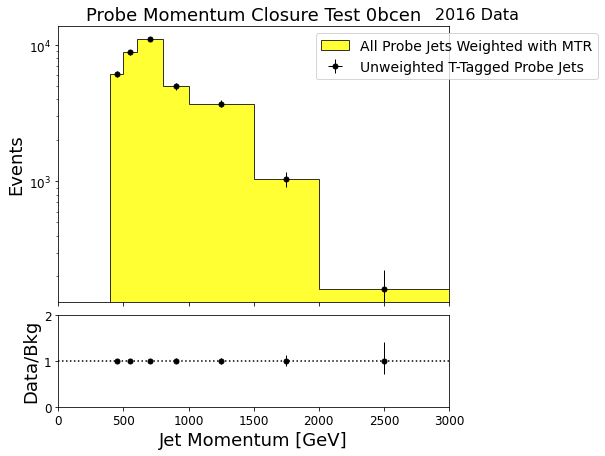

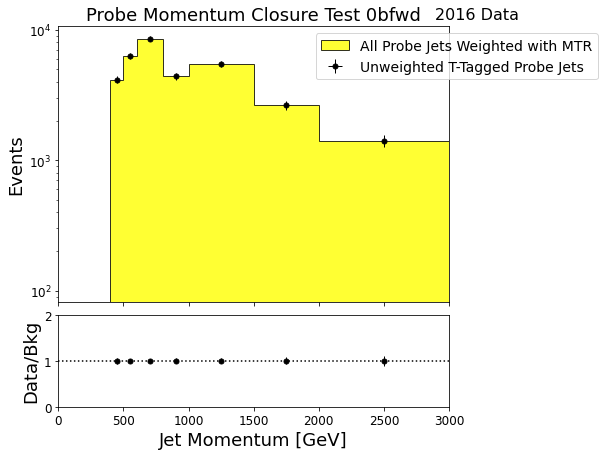

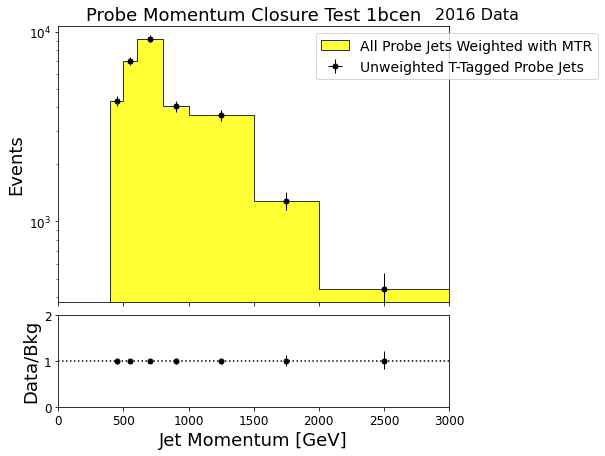

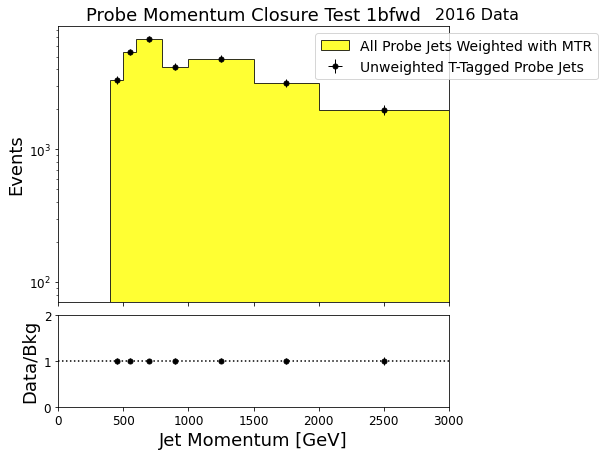

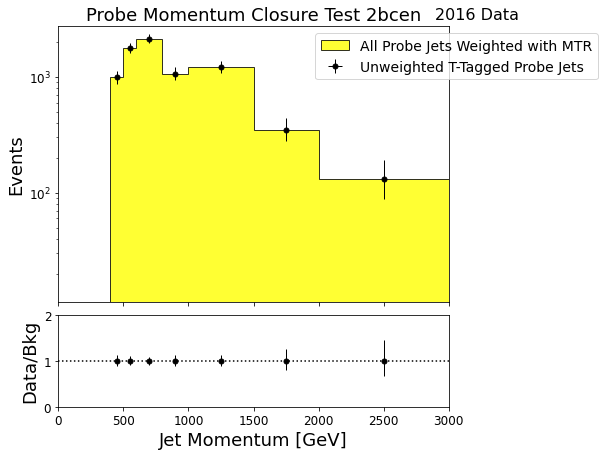

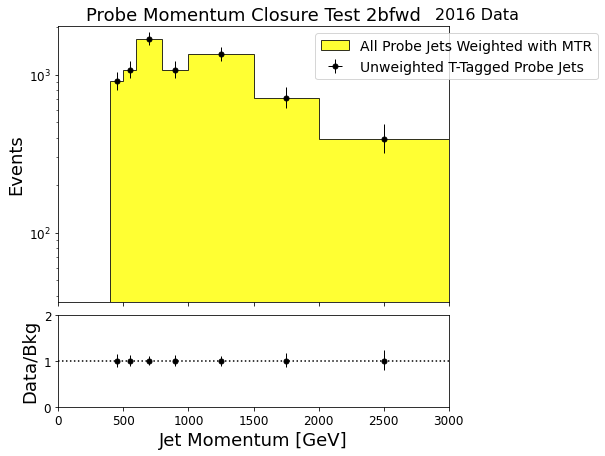

In [15]:
""" ---------- Comparing Background Estimate to unweighted Data ---------- """

for b_y in list_of_bcats:
    #---- Histogram Window Config. ----# 
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(7,7),
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.07)
    #b_y = '0bcen' # b-tag category and rapidity window

    legend_labels = {'labels':['', 'All Probe Jets Weighted with MTR', 'T-Tagged Probe Jets'],
                             'loc': 'upper right',
                             'fontsize': 'x-small'}

    #---- Useful Information (Debug Purposes Only)----# 
    lut_file = maindirectory + '/LookupTables/mistag_JetHT2016_Data_at' + b_y + '.csv'
    df = pd.read_csv(lut_file)
    p_vals = df['p'] # Momentum (GeV)
    mtr = df['M(p)'].values # Mistag Rate
    MMR = mtr.sum()/mtr.size
    print('Mean Mistag Rate (MMR) = ', MMR)

    #---- Check if these two cutflows are the same ----#
    all_evts_unwgt = JetHT2016_unweighted['cutflow']['all events']
    all_evts_wgt = JetHT2016_weighted['cutflow']['all events']
    nevts = JetHT2016_unweighted['cutflow']['at'+b_y] # Anti-tag jet
    bkg_nevts = JetHT2016_weighted['cutflow']['at'+b_y] # (Anti-tag jets) x mtr
    exp_nevts = JetHT2016_unweighted['cutflow']['AT&Pt'+b_y] # Anti-tag and t-tagged Probe pairs
    
    print('All JetHT2016 unweighted events = ', all_evts_unwgt)
    print('All JetHT2016 weighted events = ', all_evts_wgt)
    if all_evts_unwgt != all_evts_wgt:
        printColorText('\n*NOTE* This test is not accurate', 'red')
    print()
    print('Number of Unweighted "at" Data (Cutflow) = ', nevts)
    print('Number of Weighted "at" Data (Cutflow) =   ', bkg_nevts)
    print('Number of Unweighted "Probet" Data (Cutflow) = ', exp_nevts)
    print()

    #---- Define Histogram categories of interest which should be equal ----# 
    hist_wgt_anacat = 'at' + b_y # category of interest for the weighted data (all weighted probe jets)
    hist_unwgt_anacat = 'AT&Pt' + b_y # category of interest for the un-weighted data (unweighted t-tagged probe jets)
    #---- Just for Comparison... ---#
    hist_unwgt_pretag_anacat = 'at' + b_y # (all unweighted probe jets)

    #---- Given pairs of jets where one jet is anti-tagged, show the momentum of the probe jets ----#
    hist_wgt = JetHT2016_weighted['probep'].integrate('anacat', hist_wgt_anacat).integrate('dataset', JetHT2016_str[12:])
    hist_unwgt = JetHT2016_unweighted['probep'].integrate('anacat', hist_unwgt_anacat).integrate('dataset', JetHT2016_str[12:])
    hist_unwgt_pretag = JetHT2016_unweighted['probep'].integrate('anacat', hist_unwgt_pretag_anacat).integrate('dataset', JetHT2016_str[12:])

    # ---- Data Scaling ---- #
    hist_wgt.scale(Nevts2016_sf_wgt)
    hist_unwgt.scale(Nevts2016_sf) 
    hist_unwgt_pretag.scale(Nevts2016_sf)
    
    hist.plot1d(hist_wgt, ax=ax, clear=True,
                        fill_opts=stack_background_opts, error_opts=stack_error_opts) # all probe jets weighted with mistag rate (including tt contam. subtraction)
    hist.plot1d(hist_unwgt, ax=ax, clear=False,
                        error_opts=data_err_opts,
                        legend_opts=legend_labels) # all unweighted, t-tagged probe jets

    d = {'p': p_vals, 'M(p)': mtr, 
         'unwgt at'+b_y: hist_unwgt_pretag.values()[()], 
         'wgt at'+b_y: hist_wgt.values()[()], 
         'Probet'+b_y: hist_unwgt.values()[()]}
    df1 = pd.DataFrame(data=d)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
        print(df1)

    ax.set_yscale('log')
    ax.autoscale('y')
    ax.autoscale('x')#, tight=True) # doesn't look like its working...
    ax.set_ylabel('Events')
    ax.set_xlabel(None)
    ax.set_title('Probe Momentum Closure Test ' + b_y)
    leg = ax.legend(labels=[r'All Probe Jets Weighted with MTR', r'Unweighted T-Tagged Probe Jets'], bbox_to_anchor=(1.4, 1.), loc='upper right')

    #---- Plot Ratio ----#
    hist.plotratio(num = hist_unwgt, denom = hist_wgt, ax = rax,
                   error_opts=data_err_opts,
                   unc = 'num')
    rax.set_ylabel('Data/Bkg')
    rax.axhline(y=1, color='k', linestyle=':')
    rax.set_ylim(0,2)
    rax.set_xlim(0,3000)

    #---- Labeling ----#
    lumi = plt.text(1.18, 1.07, "2016 Data", #"?? fb$^{-1}$",
            fontsize=16,
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes
           )

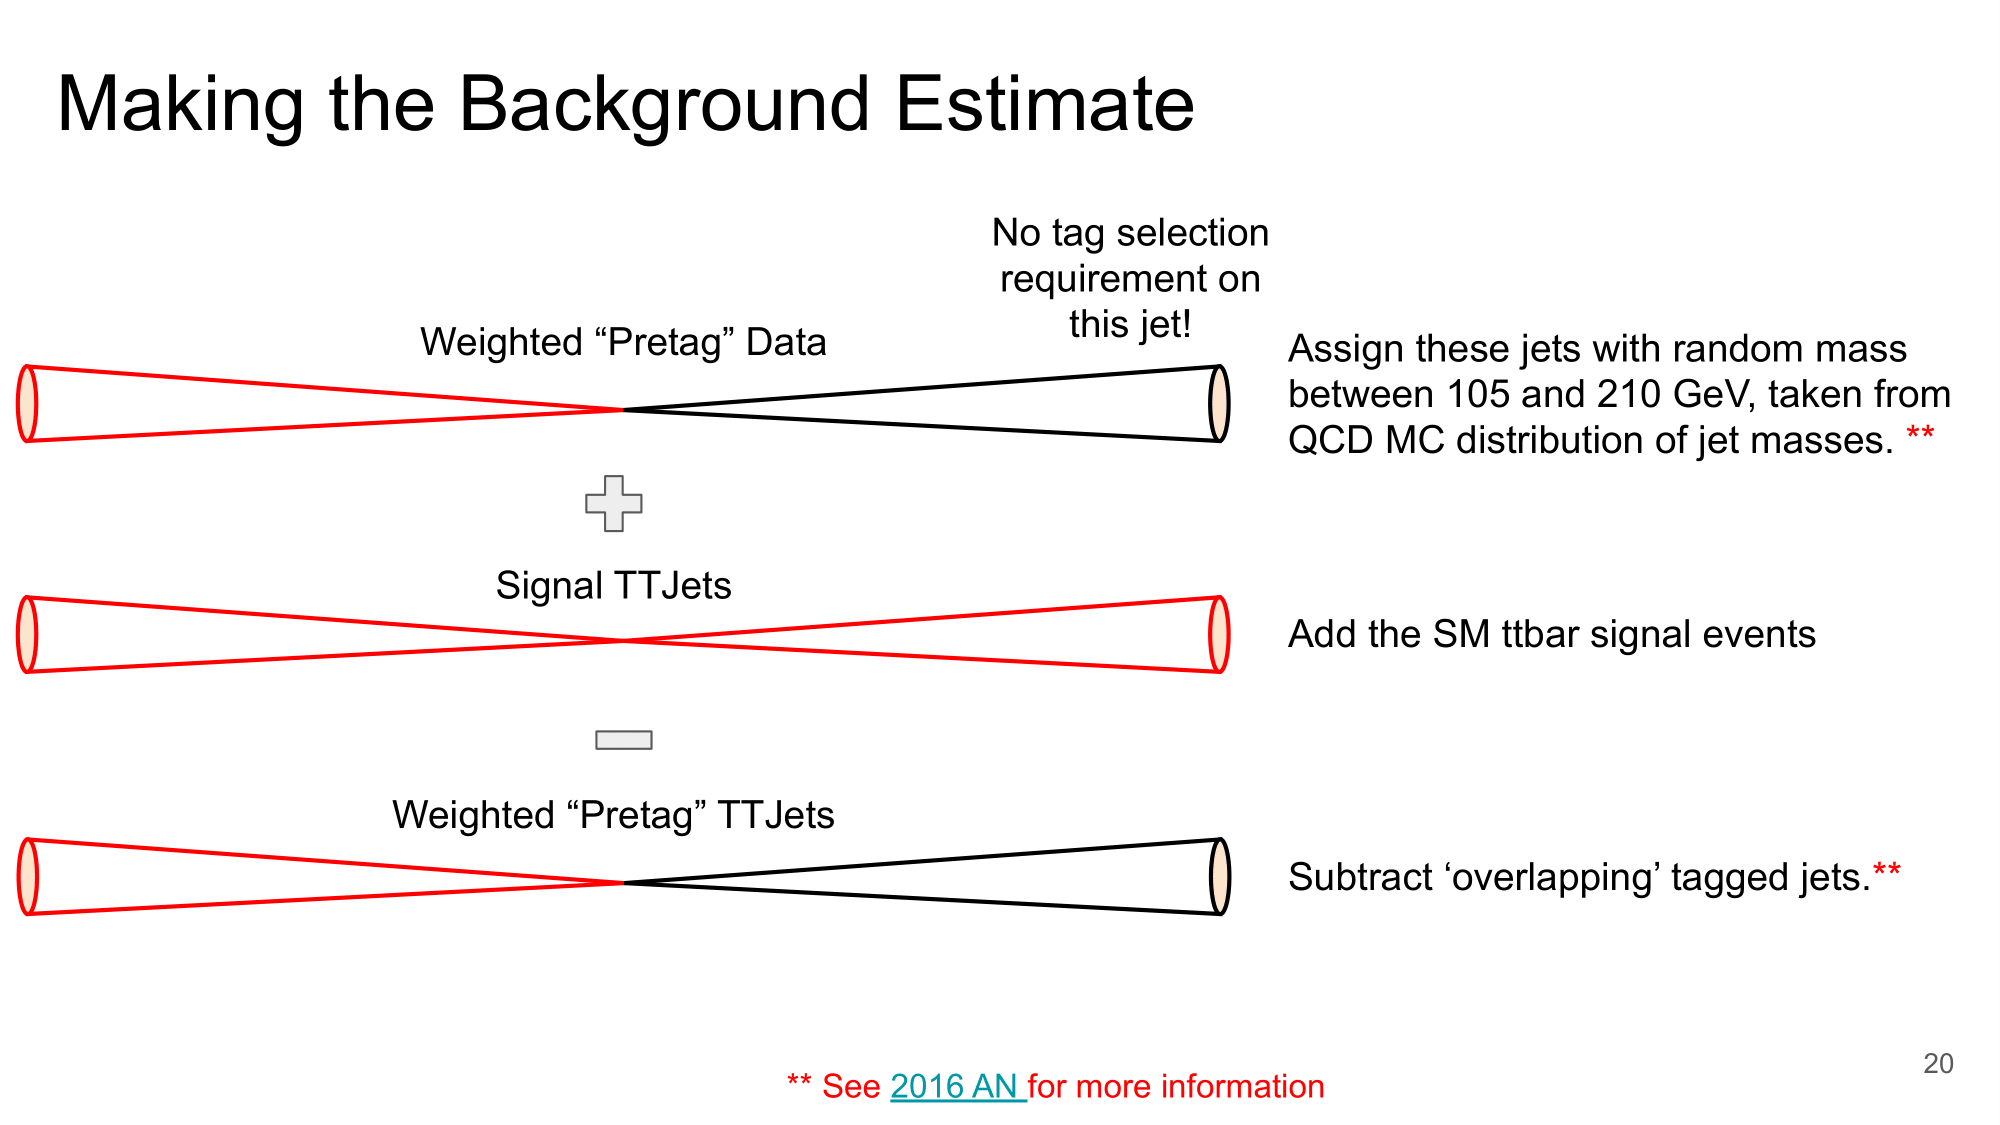

# Making the Background Estimate
## Step 1.)
### Plot NTMJ Bkg. Est. from Pre-tagged Region of Data Weighted by Mistag Rate

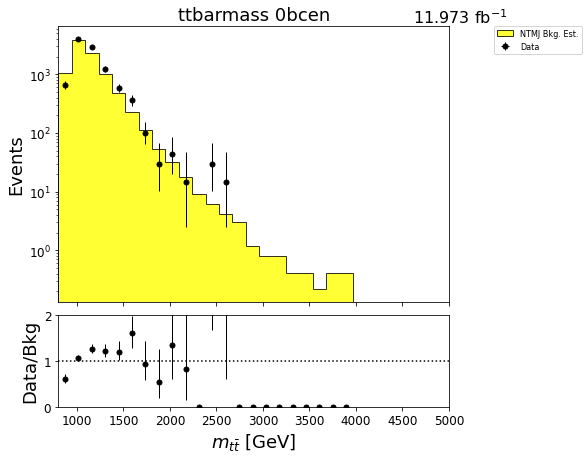

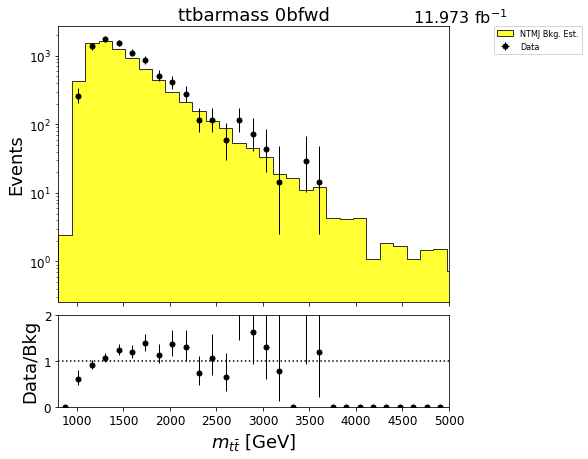

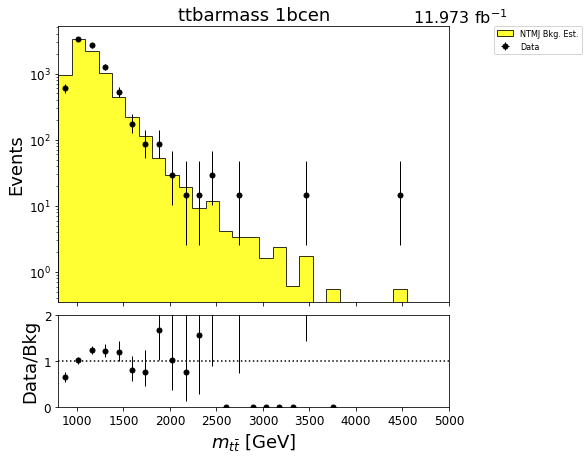

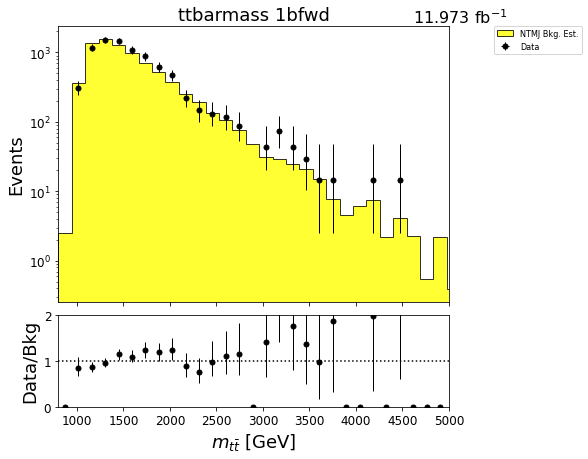

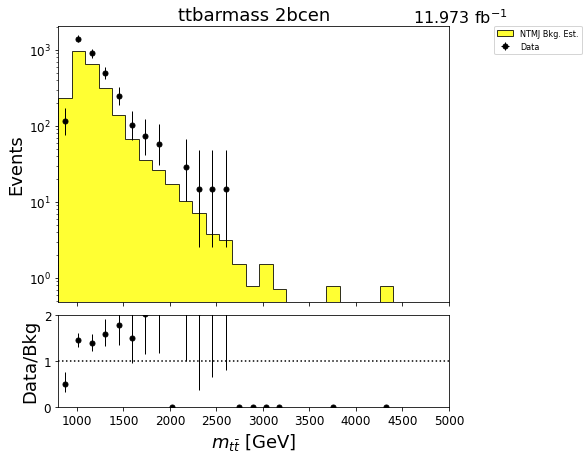

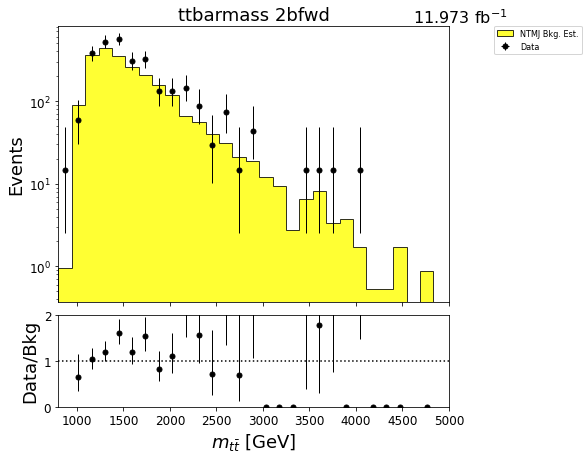

In [16]:
#---- list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi', 'jety', 'jetdy', 'probept', 'probep') ----#

name = list_of_hists[0]

for b_y in list_of_bcats:
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(7,7),
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.07)

    #---- Print cutflow of events (Debug Purposes Only)----#
    # bkg_nevts = JetHT2016_weighted['cutflow']['pret'+b_y] 
    # data_nevts = JetHT2016_unweighted['cutflow']['2t'+b_y]
    
    # =============================================================================================================================== #

    # ---- Define Histograms from Coffea Outputs ---- # 
    
    # -- For Observed Signal (Data) -- #
    Data_hist = JetHT2016_unweighted[name].integrate('anacat', '2t'+b_y).integrate('dataset', JetHT2016_str[12:])

    # -- For Mass Modified Background Estimate (Non-Top Multi-Jets; NTMJ)-- #
    NTMJ_hist = JetHT2016_weighted[name].integrate('anacat', 'pret'+b_y).integrate('dataset', JetHT2016_str[12:])

    # =============================================================================================================================== #

    # ---- Data Scaling ---- #
    Data_hist.scale(Nevts2016_sf) # Observed Signal is scaled up
    NTMJ_hist.scale(Nevts2016_sf_wgt) # NTMJ Bkg. Est. is scaled up

    # =============================================================================================================================== #

    # ---- Background and Observed Signal for Histograms ---- #

    # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate-- #
    Background = NTMJ_hist 

    # -- Simple Observed Data in Signal Region -- #
    Observed = Data_hist 

    # ---- Legend Lables for Plotting with All DM Mediator Signals ---- #
    legend_labels = {'labels':[r'NTMJ Bkg. Est.', r'Data'], 
                     'ncol':1, 
                     'loc': 'upper right', 'bbox_to_anchor': (1.35, 1.017),
                     'fontsize': 'xx-small'}



    # ---- Plot Histograms (Comment out whatever you don't want included in the figure and/or root file) ---- #
    ObservedPlot = hist.plot1d(Observed, ax=ax, clear=True,
                 error_opts=data_err_opts)
    BackgroundPlot = hist.plot1d(Background, ax=ax, clear=False,
                fill_opts=stack_background_opts,
                error_opts=stack_error_opts, legend_opts=legend_labels)


    plt.ylim(bottom = .1, top = 10**4)

    ax.set_yscale('log')
    ax.autoscale('y')
    ax.autoscale('x')#, tight=True) # doesn't look like its working...
    ax.set_ylabel('Events')
    ax.set_xlabel(None)
    ax.set_title(name + ' ' + b_y)

    #---- Plot Ratio ----#
    RatioPlot = hist.plotratio(num = Observed, denom = Background, ax = rax,
                   error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                   unc = 'num')
    rax.set_ylabel('Data/Bkg')
    rax.axhline(y=1, color='k', linestyle=':')
    rax.set_ylim(0,2)
    if 'ttbarmass' in name:
        rax.set_xlim(800,5000)
    elif 'jetpt' in name:
        rax.set_xlim(400,1500)
    elif 'jeteta' in name:
        rax.set_xlim(-2.3,2.3)
    elif 'jetphi' in name:
        rax.set_xlim(-3.14, 3.14)
    elif 'jety' in name:
        rax.set_xlim(-3., 3.)
    elif 'jetdy' in name:
        rax.set_xlim(0., 5.)
    elif 'probept' in name:
        rax.set_xlim(400., 2000.)   
    elif 'probep' in name:
        rax.set_xlim(400., 7000.)  

    #rax.set_xlim(0,500)

    #---- Labeling ----#
    Lint = str(Lum2016*.001) # Integrated Luminosity
    lumi = plt.text(1.15, 1.07, Lint[:6] + " fb$^{-1}$",
            fontsize=16,
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes
           )

# Making the Background Estimate
## Step 2.)
### Add the SM $t\bar{t}$ to the NTMJ Bkg. Est. to account for the SM contribution to the background in the signal region

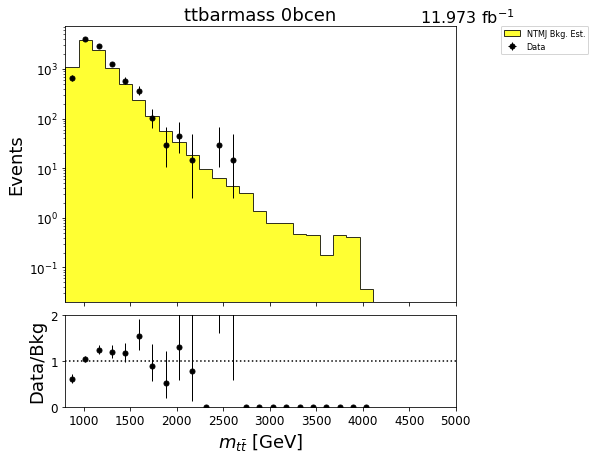

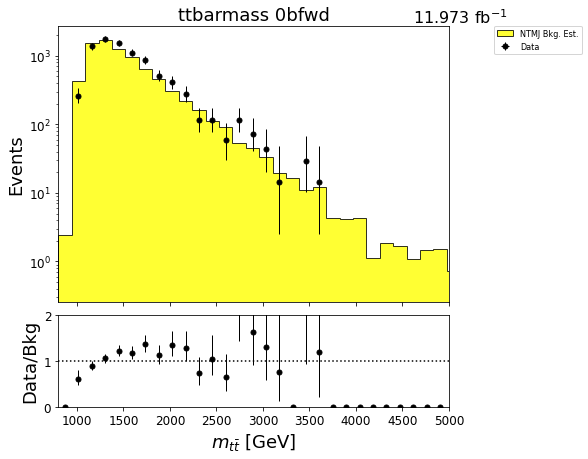

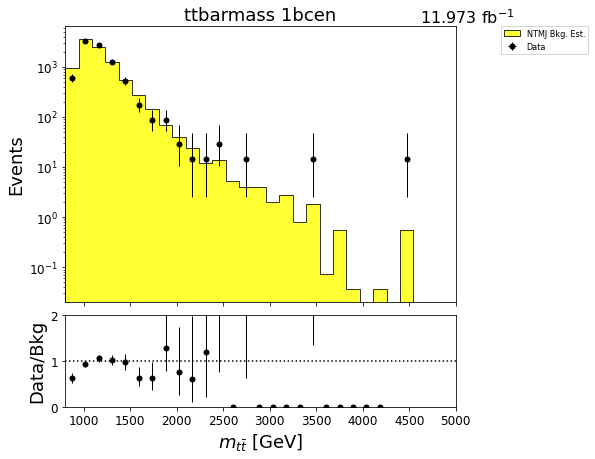

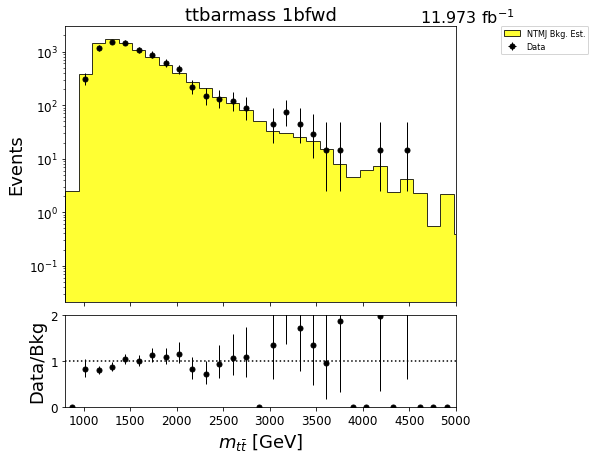

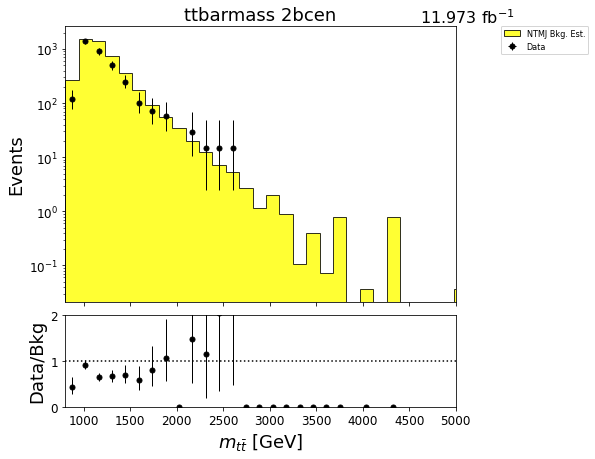

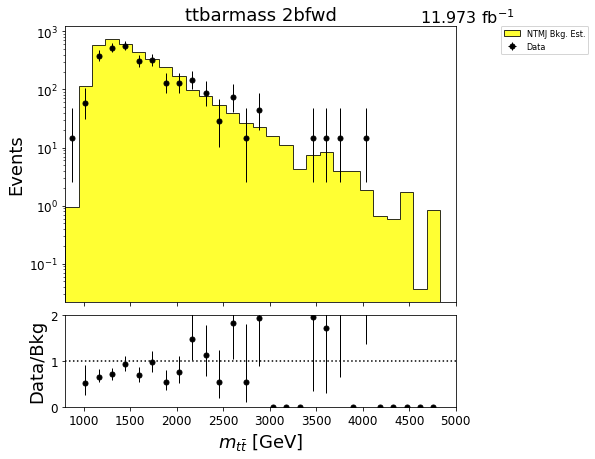

In [17]:
#---- list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi', 'jety', 'jetdy', 'probept', 'probep') ----#

name = list_of_hists[0]

for b_y in list_of_bcats:
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(7,7),
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.07)

    #---- Print cutflow of events (Debug Purposes Only)----#
    # bkg_nevts = JetHT2016_weighted['cutflow']['pret'+b_y] 
    # data_nevts = JetHT2016_unweighted['cutflow']['2t'+b_y]
    
    # =============================================================================================================================== #

    # ---- Define Histograms from Coffea Outputs ---- # 
    
    # -- For Observed Signal (Data) -- #
    Data_hist = JetHT2016_unweighted[name].integrate('anacat', '2t'+b_y).integrate('dataset', JetHT2016_str[12:])

    # -- For Mass Modified Background Estimate (Non-Top Multi-Jets; NTMJ)-- #
    NTMJ_hist = JetHT2016_weighted[name].integrate('anacat', 'pret'+b_y).integrate('dataset', JetHT2016_str[12:])
    
    # -- SM ttbar to add to bkg est -- #
    SMTTbar_hist = TTbar_unweighted[name].integrate('anacat', '2t'+b_y).integrate('dataset', TTbar_str[12:])

    # =============================================================================================================================== #

    # ---- Data Scaling ---- #
    Data_hist.scale(Nevts2016_sf) # Observed Signal is scaled up
    NTMJ_hist.scale(Nevts2016_sf_wgt) # NTMJ Bkg. Est. is scaled up
    
    # ---- MC Normalization ---- #
    SMTTbar_hist.scale(ttbar2016_sf)
    
    # =============================================================================================================================== #

    # ---- Background and Observed Signal for Histograms ---- #

    # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate -- #
    Background = NTMJ_hist 
    
    # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate, SM ttbar added -- #
    Background.add(SMTTbar_hist)

    # -- Simple Observed Data in Signal Region -- #
    Observed = Data_hist 

    # ---- Legend Lables for Plotting with All DM Mediator Signals ---- #
    legend_labels = {'labels':[r'NTMJ Bkg. Est.', r'Data'], 
                     'ncol':1, 
                     'loc': 'upper right', 'bbox_to_anchor': (1.35, 1.017),
                     'fontsize': 'xx-small'}



    # ---- Plot Histograms (Comment out whatever you don't want included in the figure and/or root file) ---- #
    ObservedPlot = hist.plot1d(Observed, ax=ax, clear=True,
                 error_opts=data_err_opts)
    BackgroundPlot = hist.plot1d(Background, ax=ax, clear=False,
                fill_opts=stack_background_opts,
                error_opts=stack_error_opts, legend_opts=legend_labels)


    plt.ylim(bottom = .1, top = 10**4)

    ax.set_yscale('log')
    ax.autoscale('y')
    ax.autoscale('x')#, tight=True) # doesn't look like its working...
    ax.set_ylabel('Events')
    ax.set_xlabel(None)
    ax.set_title(name + ' ' + b_y)

    #---- Plot Ratio ----#
    RatioPlot = hist.plotratio(num = Observed, denom = Background, ax = rax,
                   error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                   unc = 'num')
    rax.set_ylabel('Data/Bkg')
    rax.axhline(y=1, color='k', linestyle=':')
    rax.set_ylim(0,2)
    if 'ttbarmass' in name:
        rax.set_xlim(800,5000)
    elif 'jetpt' in name:
        rax.set_xlim(400,1500)
    elif 'jeteta' in name:
        rax.set_xlim(-2.3,2.3)
    elif 'jetphi' in name:
        rax.set_xlim(-3.14, 3.14)
    elif 'jety' in name:
        rax.set_xlim(-3., 3.)
    elif 'jetdy' in name:
        rax.set_xlim(0., 5.)
    elif 'probept' in name:
        rax.set_xlim(400., 2000.)   
    elif 'probep' in name:
        rax.set_xlim(400., 7000.)  

    #rax.set_xlim(0,500)

    #---- Labeling ----#
    Lint = str(Lum2016*.001) # Integrated Luminosity
    lumi = plt.text(1.15, 1.07, Lint[:6] + " fb$^{-1}$",
            fontsize=16,
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes
           )

# Making the Background Estimate
## Step 3.)
### Subtract overlapping top events from the pre-tag region

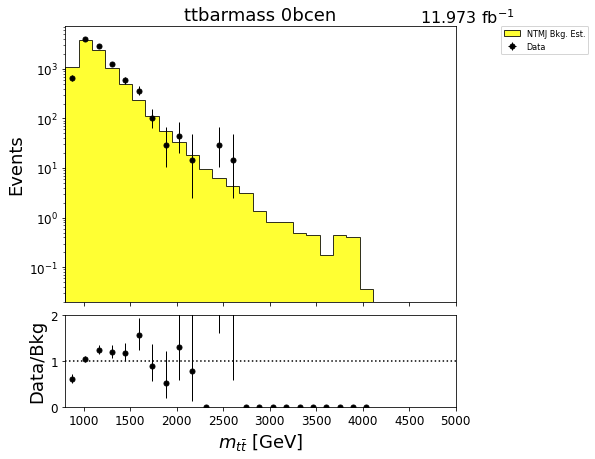

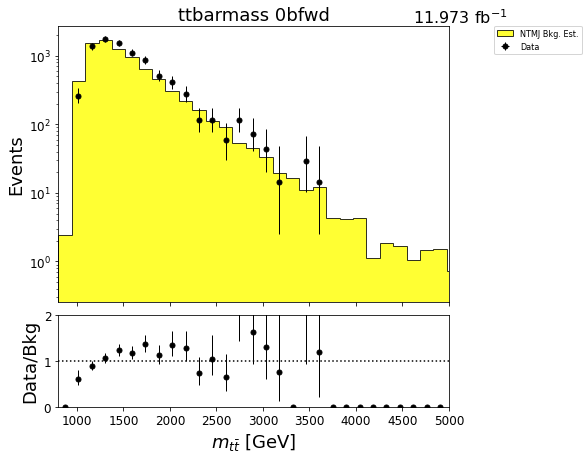

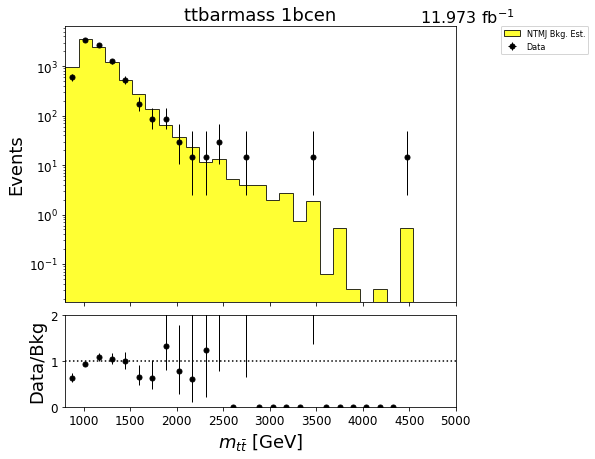

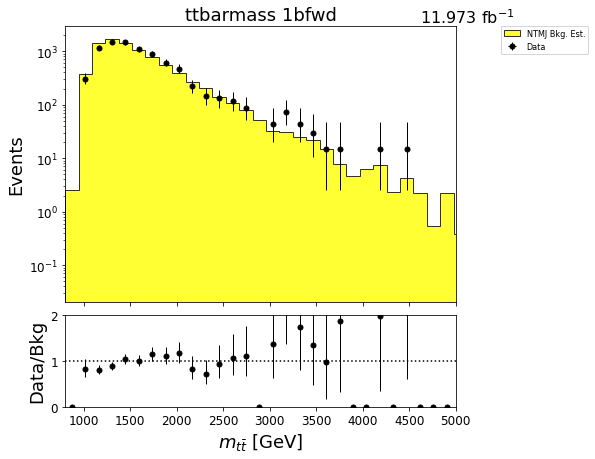

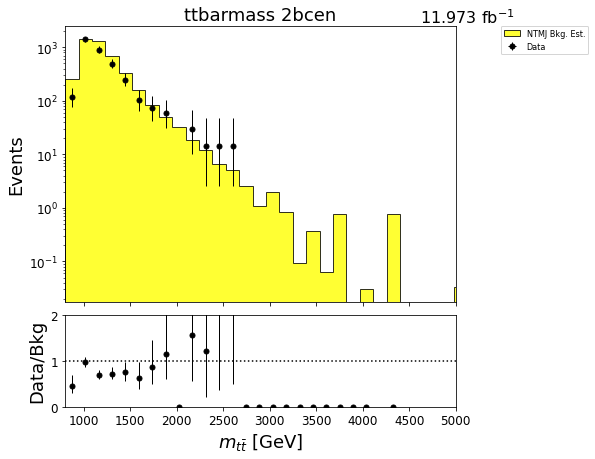

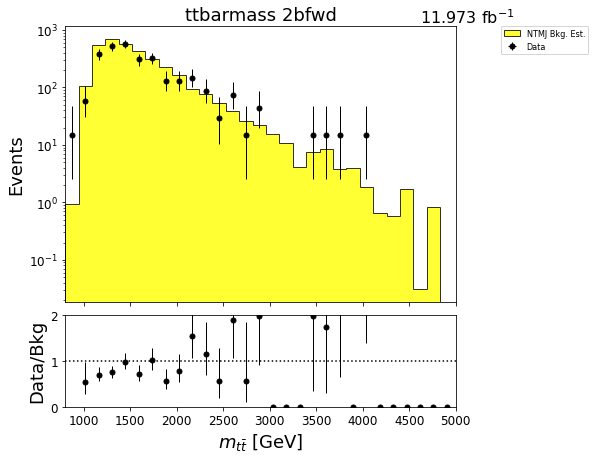

In [18]:
#---- list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi', 'jety', 'jetdy', 'probept', 'probep') ----#

name = list_of_hists[0]

for b_y in list_of_bcats:
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(7,7),
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.07)

    #---- Print cutflow of events (Debug Purposes Only)----#
    # bkg_nevts = JetHT2016_weighted['cutflow']['pret'+b_y] 
    # data_nevts = JetHT2016_unweighted['cutflow']['2t'+b_y]
    
    # =============================================================================================================================== #

    # ---- Define Histograms from Coffea Outputs ---- # 
    
    # -- For Observed Signal (Data) -- #
    Data_hist = JetHT2016_unweighted[name].integrate('anacat', '2t'+b_y).integrate('dataset', JetHT2016_str[12:])

    # -- For Mass Modified Background Estimate (Non-Top Multi-Jets; NTMJ)-- #
    NTMJ_hist = JetHT2016_weighted[name].integrate('anacat', 'pret'+b_y).integrate('dataset', JetHT2016_str[12:])
    
    # -- SM ttbar to add to bkg est -- #
    SMTTbar_hist = TTbar_unweighted[name].integrate('anacat', '2t'+b_y).integrate('dataset', TTbar_str[12:])
    
    # -- SM ttbar to add to bkg est -- #
    ExtraTTbar_hist = TTbar_weighted[name].integrate('anacat', 'pret'+b_y).integrate('dataset', TTbar_str[12:])

    # =============================================================================================================================== #

    # ---- Data Scaling ---- #
    Data_hist.scale(Nevts2016_sf) # Observed Signal is scaled up
    NTMJ_hist.scale(Nevts2016_sf_wgt) # NTMJ Bkg. Est. is scaled up
    
    # ---- MC Normalization ---- #
    SMTTbar_hist.scale(ttbar2016_sf)
    ExtraTTbar_hist.scale(-ttbar2016_sf_wgt) # note the negative sign, because COFFEA only adds hists, even though we must subtract
    
    # =============================================================================================================================== #

    # ---- Background and Observed Signal for Histograms ---- #

    # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate -- #
    Background = NTMJ_hist 
    
    # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate, SM ttbar added -- #
    Background.add(SMTTbar_hist)
    
    # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate, SM ttbar added, Double Counting ttbar Subtracted -- #
    Background.add(ExtraTTbar_hist)

    # -- Simple Observed Data in Signal Region -- #
    Observed = Data_hist 

    # ---- Legend Lables for Plotting with All DM Mediator Signals ---- #
    legend_labels = {'labels':[r'NTMJ Bkg. Est.', r'Data'], 
                     'ncol':1, 
                     'loc': 'upper right', 'bbox_to_anchor': (1.35, 1.017),
                     'fontsize': 'xx-small'}



    # ---- Plot Histograms (Comment out whatever you don't want included in the figure and/or root file) ---- #
    ObservedPlot = hist.plot1d(Observed, ax=ax, clear=True,
                 error_opts=data_err_opts)
    BackgroundPlot = hist.plot1d(Background, ax=ax, clear=False,
                fill_opts=stack_background_opts,
                error_opts=stack_error_opts, legend_opts=legend_labels)


    plt.ylim(bottom = .1, top = 10**4)

    ax.set_yscale('log')
    ax.autoscale('y')
    ax.autoscale('x')#, tight=True) # doesn't look like its working...
    ax.set_ylabel('Events')
    ax.set_xlabel(None)
    ax.set_title(name + ' ' + b_y)

    #---- Plot Ratio ----#
    RatioPlot = hist.plotratio(num = Observed, denom = Background, ax = rax,
                   error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                   unc = 'num')
    rax.set_ylabel('Data/Bkg')
    rax.axhline(y=1, color='k', linestyle=':')
    rax.set_ylim(0,2)
    if 'ttbarmass' in name:
        rax.set_xlim(800,5000)
    elif 'jetpt' in name:
        rax.set_xlim(400,1500)
    elif 'jeteta' in name:
        rax.set_xlim(-2.3,2.3)
    elif 'jetphi' in name:
        rax.set_xlim(-3.14, 3.14)
    elif 'jety' in name:
        rax.set_xlim(-3., 3.)
    elif 'jetdy' in name:
        rax.set_xlim(0., 5.)
    elif 'probept' in name:
        rax.set_xlim(400., 2000.)   
    elif 'probep' in name:
        rax.set_xlim(400., 7000.)  

    #rax.set_xlim(0,500)

    #---- Labeling ----#
    Lint = str(Lum2016*.001) # Integrated Luminosity
    lumi = plt.text(1.15, 1.07, Lint[:6] + " fb$^{-1}$",
            fontsize=16,
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes
           )

# Visualize All Three Steps Together

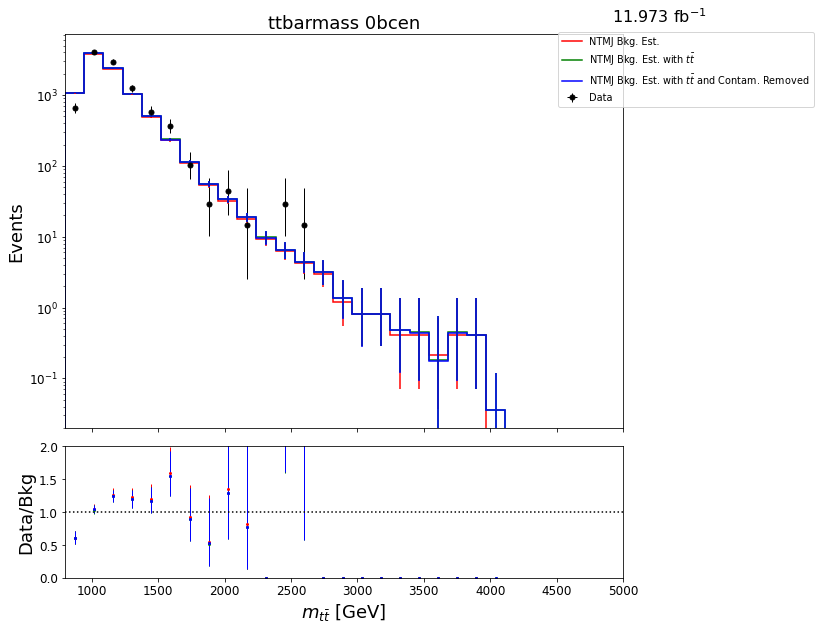

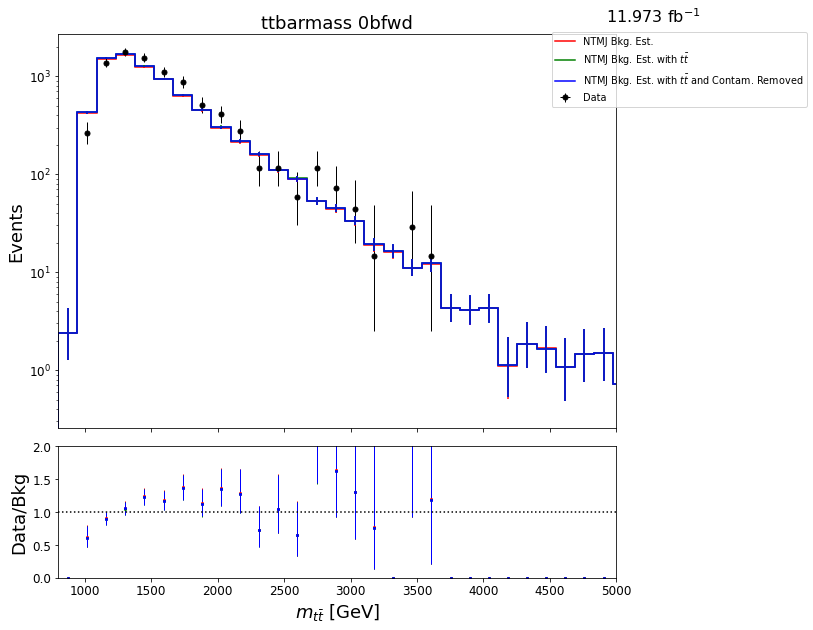

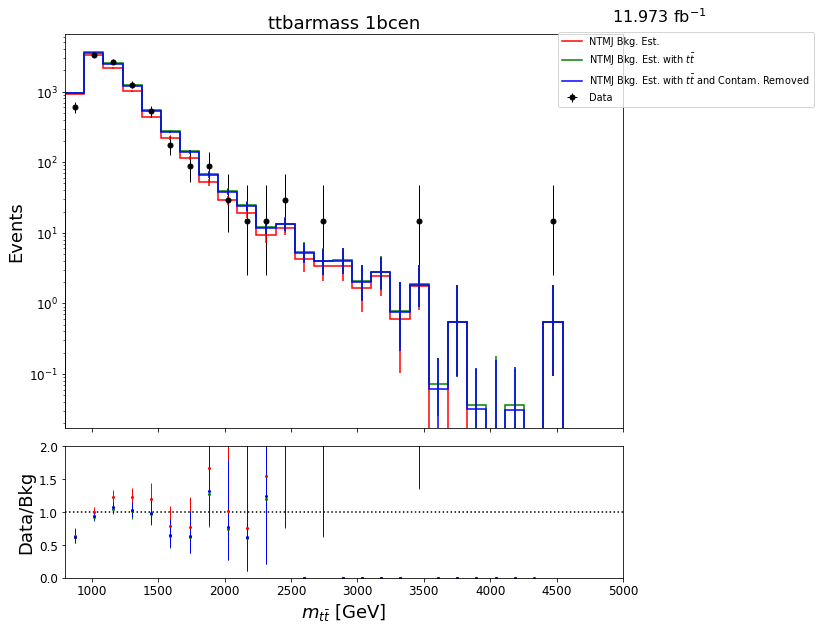

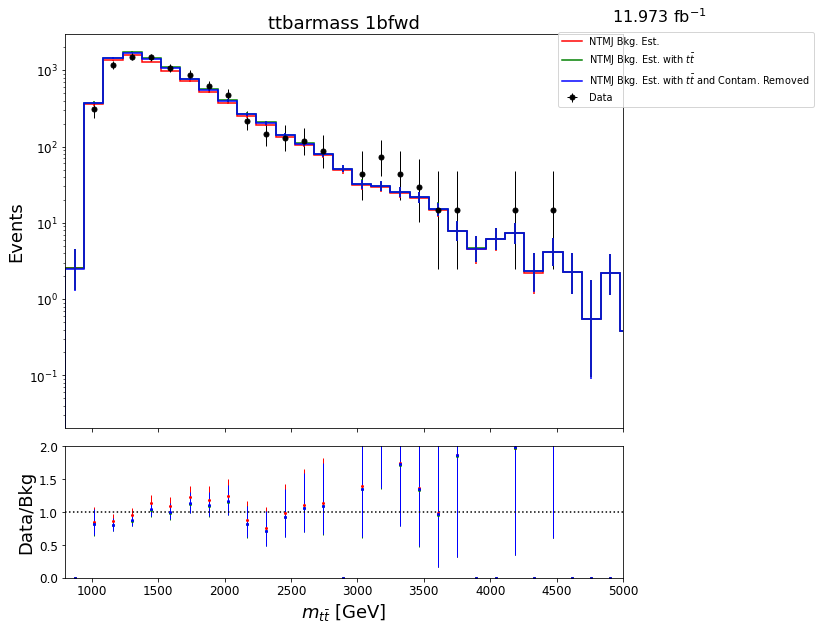

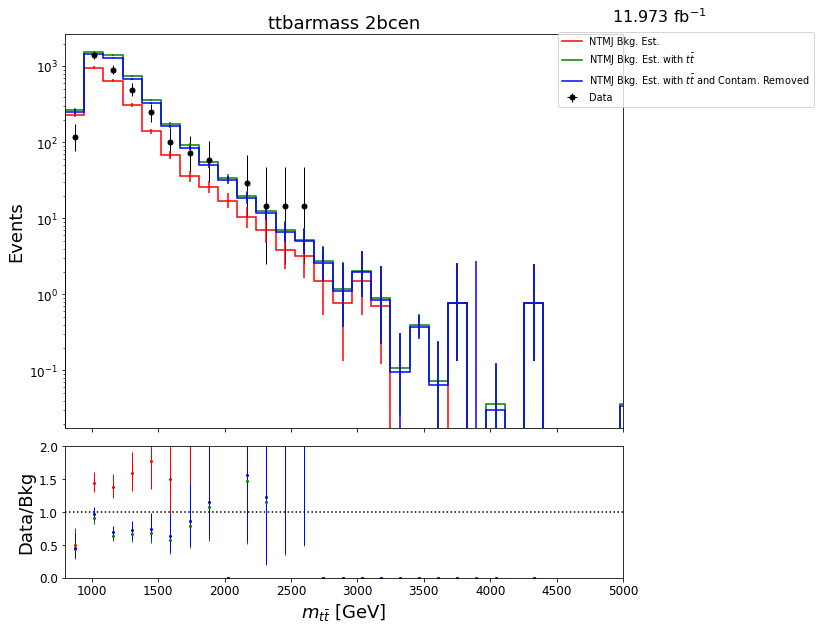

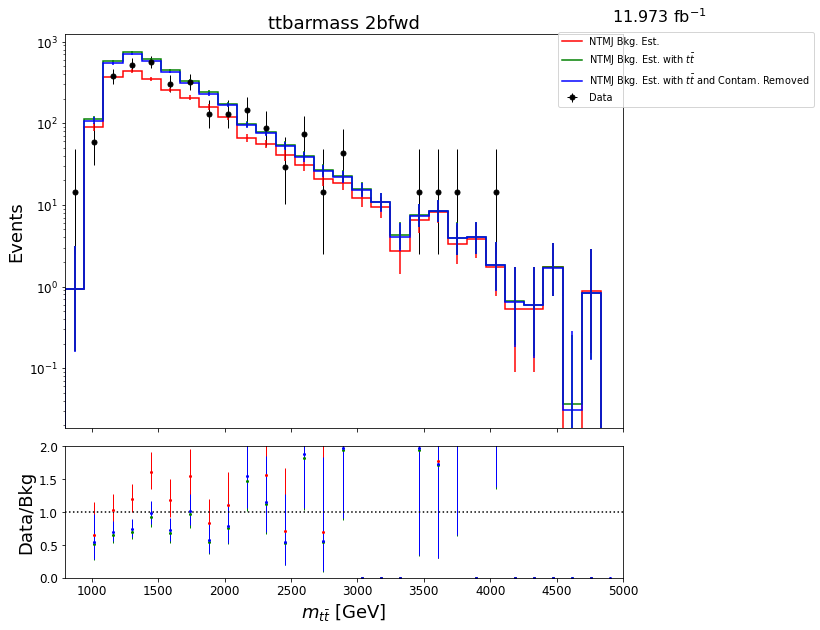

In [19]:
#---- list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi', 'jety', 'jetdy', 'probept', 'probep') ----#

name = list_of_hists[0]

for b_y in list_of_bcats:
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10,10),
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.07)

    #---- Print cutflow of events (Debug Purposes Only)----#
    # bkg_nevts = JetHT2016_weighted['cutflow']['pret'+b_y] 
    # data_nevts = JetHT2016_unweighted['cutflow']['2t'+b_y]
    
    # =============================================================================================================================== #

    # ---- Define Histograms from Coffea Outputs ---- # 
    
    # -- For Observed Signal (Data) -- #
    Data_hist = JetHT2016_unweighted[name].integrate('anacat', '2t'+b_y).integrate('dataset', JetHT2016_str[12:])

    # -- For Mass Modified Background Estimate (Non-Top Multi-Jets; NTMJ)-- #
    NTMJ_hist = JetHT2016_weighted[name].integrate('anacat', 'pret'+b_y).integrate('dataset', JetHT2016_str[12:])
    
    # -- SM ttbar to add to bkg est -- #
    SMTTbar_hist = TTbar_unweighted[name].integrate('anacat', '2t'+b_y).integrate('dataset', TTbar_str[12:])
    
    # -- SM ttbar to add to bkg est -- #
    ExtraTTbar_hist = TTbar_weighted[name].integrate('anacat', 'pret'+b_y).integrate('dataset', TTbar_str[12:])

    # =============================================================================================================================== #

    # ---- Data Scaling ---- #
    Data_hist.scale(Nevts2016_sf) # Observed Signal is scaled up
    NTMJ_hist.scale(Nevts2016_sf_wgt) # NTMJ Bkg. Est. is scaled up
    
    # ---- MC Normalization ---- #
    SMTTbar_hist.scale(ttbar2016_sf)
    ExtraTTbar_hist.scale(-ttbar2016_sf_wgt) # note the negative sign, because COFFEA only adds hists, even though we must subtract

    # =============================================================================================================================== #

    # ---- Background and Observed Signal for Histograms ---- #

    # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate -- #
    Background = NTMJ_hist 
    Background_step1 = Background.copy()
    Background_step2 = Background.copy()
    Background_step3 = Background.copy()
    
    # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate, SM ttbar added -- #
    Background_step2.add(SMTTbar_hist)
    
    # -- J0 t-tagged, J1 Mass Modified, Events weighted with mistag rate, SM ttbar added, Double Counting ttbar Subtracted -- #
    Background_step3.add(SMTTbar_hist)
    Background_step3.add(ExtraTTbar_hist)

    # -- Simple Observed Data in Signal Region -- #
    Observed = Data_hist 

    # ---- Legend Lables for Plotting with All DM Mediator Signals ---- #
    legend_labels = {'labels':[r'NTMJ Bkg. Est.', r'NTMJ Bkg. Est. with $t\bar{t}$', r'NTMJ Bkg. Est. with $t\bar{t}$ and Contam. Removed', r'Data'], 
                     'ncol':1, 
                     'loc': 'upper right', 'bbox_to_anchor': (1.35, 1.017),
                     'fontsize': 'x-small'}



    # ---- Plot Histograms (Comment out whatever you don't want included in the figure and/or root file) ---- #
    ObservedPlot = hist.plot1d(Observed, ax=ax, clear=True,
                 error_opts=data_err_opts)
    BackgroundPlot1 = hist.plot1d(Background_step1, ax=ax, clear=False,
                line_opts=line_background_opts1,
                error_opts=stack_error_opts)
    BackgroundPlot2 = hist.plot1d(Background_step2, ax=ax, clear=False,
                line_opts=line_background_opts2,
                error_opts=stack_error_opts)
    BackgroundPlot3 = hist.plot1d(Background_step3, ax=ax, clear=False,
                line_opts=line_background_opts3,
                error_opts=stack_error_opts, legend_opts=legend_labels)


    plt.ylim(bottom = .1, top = 10**4)

    ax.set_yscale('log')
    ax.autoscale('y')
    ax.autoscale('x')#, tight=True) # doesn't look like its working...
    ax.set_ylabel('Events')
    ax.set_xlabel(None)
    ax.set_title(name + ' ' + b_y)

    #---- Plot Ratio ----#
    RatioPlot1 = hist.plotratio(num = Observed, denom = Background_step1, ax = rax, clear=True,
                   error_opts={'marker': '.', 'markersize': 4., 'color': 'r', 'elinewidth': 1},
                   unc = 'num')
    RatioPlot2 = hist.plotratio(num = Observed, denom = Background_step2, ax = rax, clear=False,
                   error_opts={'marker': '.', 'markersize': 4., 'color': 'g', 'elinewidth': 1},
                   unc = 'num')
    RatioPlot3 = hist.plotratio(num = Observed, denom = Background_step3, ax = rax, clear=False,
                   error_opts={'marker': '.', 'markersize': 4., 'color': 'b', 'elinewidth': 1},
                   unc = 'num')
    rax.set_ylabel('Data/Bkg')
    rax.axhline(y=1, color='k', linestyle=':')
    rax.set_ylim(0,2)
    if 'ttbarmass' in name:
        rax.set_xlim(800,5000)
    elif 'jetpt' in name:
        rax.set_xlim(400,1500)
    elif 'jeteta' in name:
        rax.set_xlim(-2.3,2.3)
    elif 'jetphi' in name:
        rax.set_xlim(-3.14, 3.14)
    elif 'jety' in name:
        rax.set_xlim(-3., 3.)
    elif 'jetdy' in name:
        rax.set_xlim(0., 5.)
    elif 'probept' in name:
        rax.set_xlim(400., 2000.)   
    elif 'probep' in name:
        rax.set_xlim(400., 7000.)  

    #rax.set_xlim(0,500)

    #---- Labeling ----#
    Lint = str(Lum2016*.001) # Integrated Luminosity
    lumi = plt.text(1.15, 1.07, Lint[:6] + " fb$^{-1}$",
            fontsize=16,
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes
           )